=== Matriz de Hückel H (eV) ===
      O(1)  C(2)  N(3)  C(4)  C(5)
O(1)  -2.5  -2.0  0.00  0.00 -2.00
C(2)  -2.0   0.0 -2.50  0.00  0.00
N(3)   0.0  -2.5 -1.25 -2.00  0.00
C(4)   0.0   0.0 -2.00  0.00 -2.75
C(5)  -2.0   0.0  0.00 -2.75  0.00

=== k usados por ligação ===
O(1)–C(2): k = 0.800
C(2)–N(3): k = 1.000
N(3)–C(4): k = 0.800
C(4)–C(5): k = 1.100
C(5)–O(1): k = 0.800

=== Energias (eV) ===
MO1: -5.357236
MO2: -2.662018 (HOMO)
MO3: -1.961425 (LUMO)
MO4: 2.671873
MO5: 3.558805

=== Orbitais Moleculares (combinação linear) ===
ψ_MO1 = +0.577*O(1) +0.419*C(2) +0.435*N(3) +0.371*C(4) +0.406*C(5)
ψ_MO2 = +0.658*O(1) -0.118*C(2) -0.652*N(3) -0.313*C(4) +0.171*C(5)
ψ_MO3 = -0.209*O(1) -0.514*C(2) -0.236*N(3) +0.558*C(4) +0.570*C(5)
ψ_MO4 = +0.415*O(1) -0.714*C(2) +0.431*N(3) +0.047*C(4) -0.360*C(5)
ψ_MO5 = +0.133*O(1) +0.192*C(2) -0.379*N(3) +0.671*C(4) -0.593*C(5)

=== Populações eletrônicas π ===
O(1): 1.576
C(2): 0.642
N(3): 1.286
C(4): 0.783
C(5): 0.713
Soma dos PETs: 5.000

=== Ord

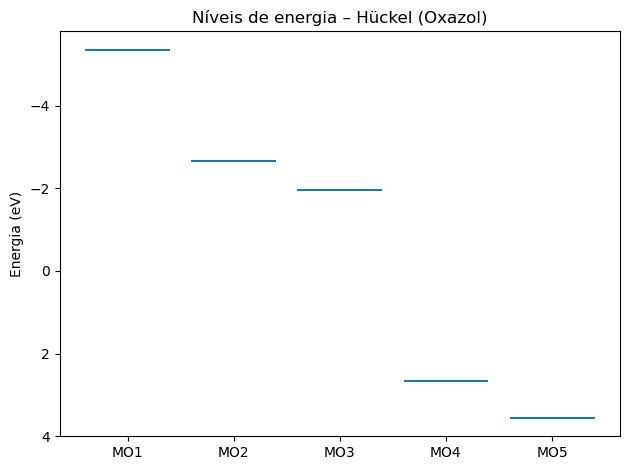

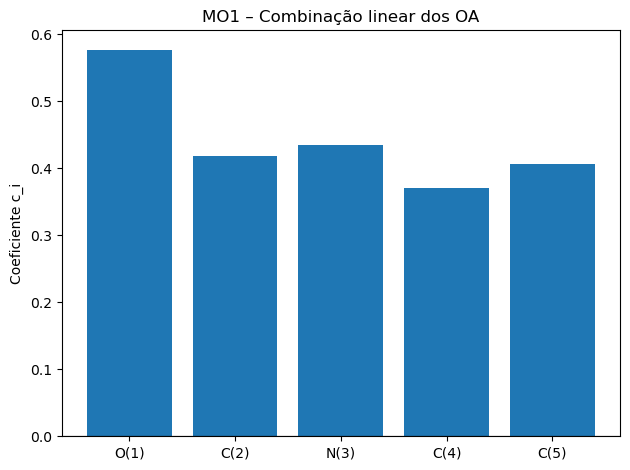

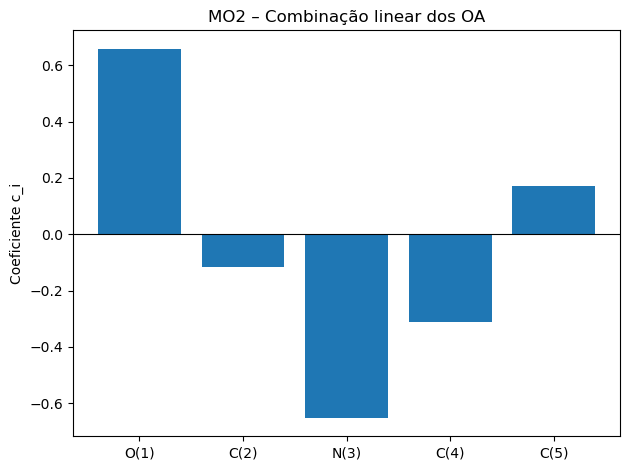

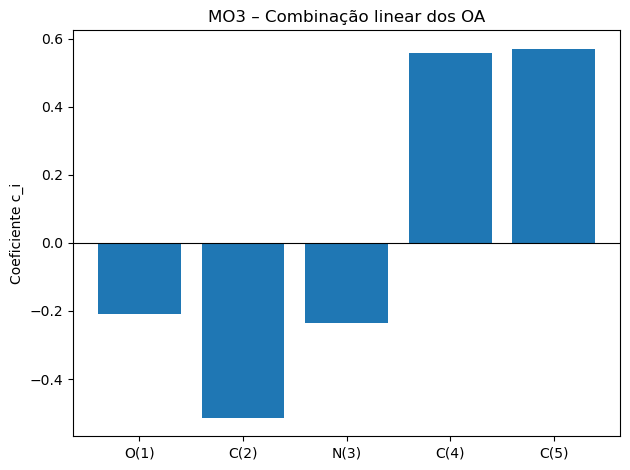

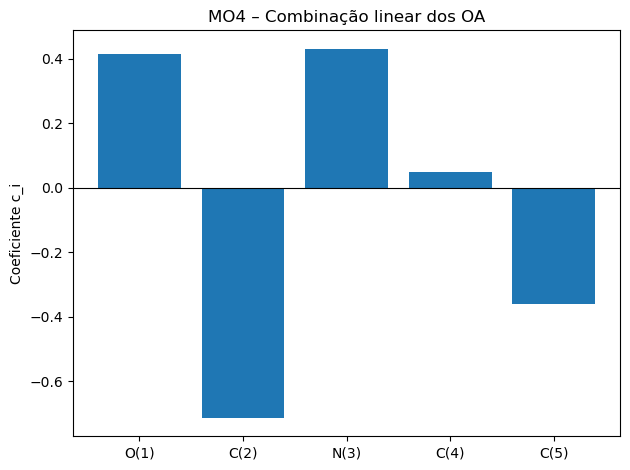

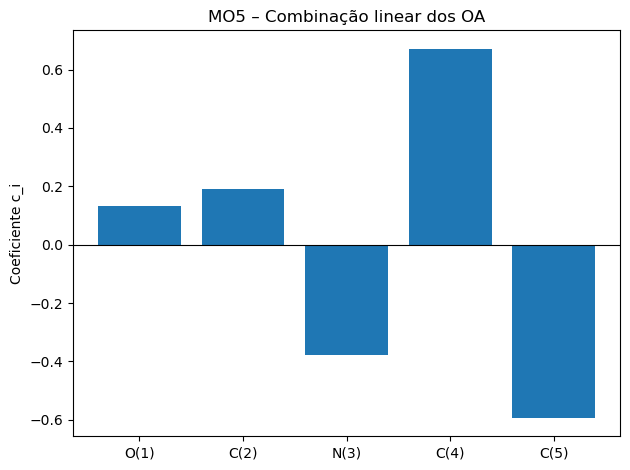

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Parâmetros
# -------------------------
beta0  = -2.5  # eV
alphaC = 0.0

h = {
    "C": 0.0,
    "N_piridina": 0.5,
    "O_furano":   1.0,
}

k_aromatic = {
    ("C","C"): 1.0,
    ("C","N_piridina"): 0.8,
    ("C","O_furano"):   0.8,
}

# -------------------------
# 2) Molécula
# -------------------------
atoms  = ["O_furano", "C", "N_piridina", "C", "C"]
labels = ["O(1)", "C(2)", "N(3)", "C(4)", "C(5)"]

bonds = [
    (0, 1, "aromatic"),  # O–C
    (1, 2, "double"),    # C=N
    (2, 3, "aromatic"),  # N–C
    (3, 4, "double"),    # C=C
    (4, 0, "aromatic"),  # C–O
]

# -------------------------
# 3) Matriz de Hückel
# -------------------------
n = len(atoms)
H = np.zeros((n, n))

for i, ax in enumerate(atoms):
    H[i, i] = alphaC + h[ax] * beta0

def k_default(a_i, a_j):
    if (a_i, a_j) in k_aromatic:
        return k_aromatic[(a_i, a_j)]
    if (a_j, a_i) in k_aromatic:
        return k_aromatic[(a_j, a_i)]
    return 0.0

def k_for_bond(i, j, bond_type):
    ai, aj = atoms[i], atoms[j]
    if bond_type == "double":
        if {"N_piridina","C"} == {ai, aj}:
            return 1.0
        if ai == "C" and aj == "C":
            return 1.1
        return 1.0
    elif bond_type == "single":
        if {"N_piridina","C"} == {ai, aj}:
            return 0.7
        if ai == "C" and aj == "C":
            return 0.9
        if {"O_furano","C"} == {ai, aj}:
            return 0.8
        return k_default(ai, aj)
    else:
        return k_default(ai, aj)

k_used = {}
for i, j, btype in bonds:
    kij = k_for_bond(i, j, btype)
    H[i, j] = H[j, i] = kij * beta0
    k_used[(i, j)] = kij

# -------------------------
# 4) Diagonalização
# -------------------------
evals, evecs = np.linalg.eigh(H)

# -------------------------
# 5) Preenchimento eletrônico (5 elétrons π)
# -------------------------
nelec = 5
full_occ = nelec // 2
half_occ = nelec % 2

occ_e = np.zeros(n)
occ_e[:full_occ] = 2.0
if half_occ:
    occ_e[full_occ] = 1.0

# Populações
populations = np.sum((evecs**2) * occ_e, axis=1)
PET_total = np.sum(populations)

# Ordens de ligação π
P = np.zeros((n, n))
for a in range(n):
    P += occ_e[a] * np.outer(evecs[:, a], evecs[:, a])

# -------------------------
# 6) Impressão de resultados
# -------------------------
print("=== Matriz de Hückel H (eV) ===")
print(pd.DataFrame(H, index=labels, columns=labels))

print("\n=== k usados por ligação ===")
for (i,j), kij in k_used.items():
    print(f"{labels[i]}–{labels[j]}: k = {kij:.3f}")

print("\n=== Energias (eV) ===")
for m, E in enumerate(evals, 1):
    tag = " (HOMO)" if m == full_occ else (" (LUMO)" if m == full_occ+1 else "")
    print(f"MO{m}: {E:.6f}{tag}")

print("\n=== Orbitais Moleculares (combinação linear) ===")
for m in range(n):
    terms = [f"{evecs[i,m]:+.3f}*{labels[i]}" for i in range(n)]
    print(f"ψ_MO{m+1} = " + " ".join(terms))

print("\n=== Populações eletrônicas π ===")
for lbl, Ni in zip(labels, populations):
    print(f"{lbl}: {Ni:.3f}")
print(f"Soma dos PETs: {PET_total:.3f}")

print("\n=== Ordens de ligação π ===")
for i, j, _ in bonds:
    print(f"{labels[i]}–{labels[j]}: {P[i,j]:.3f}")

# -------------------------
# 7) Plots
# -------------------------
# Níveis de energia
plt.figure()
x = np.arange(1, n+1)
plt.hlines(evals, x-0.4, x+0.4)
plt.xticks(x, [f"MO{j}" for j in range(1, n+1)])
plt.ylabel("Energia (eV)")
plt.title("Níveis de energia – Hückel (Oxazol)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plots dos 5 MOs
for mo_index in range(n):
    coeffs = evecs[:, mo_index]
    plt.figure()
    plt.bar(labels, coeffs)
    plt.ylabel("Coeficiente c_i")
    plt.title(f"MO{mo_index+1} – Combinação linear dos OA")
    plt.axhline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()
